# 500px Machine Learning Engineer Intern - Tech Challenge
## Fooling an MNIST Classifier with Adversarial Images, using TensorFlow

## Description

Create adversarial images to fool a MNIST classifier in TensorFlow.

Deep convolutional neural networks (CNN) are state of the art models for image classification and object detection. Such models play crucial role at 500px where we use them for many applications like automatic keywording, people detection and image search. It’s important to understand how they work and what their limitations are.
One known “limitation” of CNN is that they can be fooled to misclassify an image with high confidence by slightly
perturbing the pixels. 

This is illustrated on the image below:

![](https://lh4.googleusercontent.com/Bz7CFzzMBRkKJ4xGqMTpufuL35Lf69z3DEoDAV-ZzD1OC9lMHYL4co0ED-LF2URMowvbDdqkRg6oxZHWeIspOVDkeaB0rqAfNpRHXfrhxS45U2cqsuX52J2GZwlFOB0TSc_rYxu7)

The delta between the original image and the adversarial one is so small that it is impossible for humans to detect. The fun fact is other machine learning models like SVM and logistic regression can be tricked in the similar manner.

Note that the “fast gradient sign” method presented in the [original paper by Goodfellow](https://arxiv.org/abs/1412.6572) produces adversarial images for a random target class. In this challenge we would like to generate adversarial images to misclassify any examples of ‘2’ as ‘6’ specifically. This puts certain implications on the final solution.

One of the useful application for adversarial images is that if you train your deep CNN classifier on them you can improve its accuracy on non-adversarial examples.

In this challenge you are given an opportunity to learn how to generate adversarial examples and also gain practical experience using Tensorflow.

### Getting Started

Let's start by importing dependencies, and loading up the MNIST dataset. Note that much of the code in this section, and sections to come, is repurposed from [this tutorial](https://www.tensorflow.org/versions/r0.11/tutorials/mnist/pros/#deep-mnist-for-experts).

Also, let's write functions to save a trained model and load a trained model, since we'll be doing quite a bit of that and it'll spare us from having to re-train all the time. And add a function that visualizes heatmaps, since we'll be doing quite a bit of that as well (note that the plotHeatmap function is modified from a project I'd previously completed, the code can be found [here](https://github.com/MunirAD/Facial_Recognition_AlexNet/blob/master/part3.py).


In [49]:
%matplotlib notebook

import tensorflow as tf
import numpy as np
import cPickle as pickle 
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

sess = tf.InteractiveSession()
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

def save_model(model, filename):
    if os.path.exists(filename):
        print("The file '" + filename + "' already exists in the cwd")
        return
    with open(filename, 'w') as fp:
        pickle.dump(model, fp)
    
def load_model(filename):
    if not os.path.exists(filename):
        print("The file '" + filename + "' does not exist in the cwd")
        return
    with open(filename, 'r') as fp:
        model = pickle.load(fp)
    return model

def plotHeatmap(x, size):
    fig = plt.figure()
    ax = fig.gca()
    gray_scale_img = x.reshape((size, size))
    heatmap = ax.imshow(gray_scale_img, cmap = mpl.cm.coolwarm)
    fig.colorbar(heatmap, shrink = 0.5, aspect=5)
    plt.show()

Exception AssertionError: AssertionError("Nesting violated for default stack of <type 'weakref'> objects",) in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x121a896d0>> ignored


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Vanilla Neural Network 

Now that we have the data, let's get our feet wet with TensorFlow by implementing a basic fully connected neural network with one hidden layer, and see how it performs on the data. Note that aside from using the TensorFlow code mentioned earlier, much of this code is repurposed from an earlier project I've completed, which can be found [here](https://github.com/MunirAD/Facial_Recognition_AlexNet/blob/master/part2.py) (in the `fully_connected` function code).



In [57]:
def FullyConnectedNet(num_in, num_hid, num_out, lam, learn_rate, num_epochs, batch_size):
    
    # Set up a placeholder for the input 'x' and its label 'y_' 
    # Note the label is in one-of-k (one-hot) encoding
    x = tf.placeholder(tf.float32, [None, num_in])
    y_ = tf.placeholder(tf.float32, [None, num_out])

    # Set up variables for the network parameters. Note this is a single-hidden
    # layer network
    W0 = tf.Variable(tf.random_normal([num_in, num_hid], stddev=0.01))
    b0 = tf.Variable(tf.random_normal([num_hid], stddev=0.01))
    W1 = tf.Variable(tf.random_normal([num_hid, num_out], stddev=0.01))
    b1 = tf.Variable(tf.random_normal([num_out], stddev=0.01))
    
    # Initialize the variables
    sess.run(tf.initialize_all_variables())
    
    # Set up the computation of a forward pass on an input to the net
    layer1 = tf.nn.relu(tf.matmul(x, W0) + b0)
    layer2 = tf.matmul(layer1, W1) + b1
    y = tf.nn.softmax(layer2)
    
    # Set up a decay penalty to regularize, reducing the risk of over-fitting
    decay_penalty = lam*tf.reduce_sum(tf.square(W0)) + lam*tf.reduce_sum(tf.square(W1))
    NLL = -tf.reduce_sum(y_*tf.log(y)) + decay_penalty
    
    # Set up the Gradient Descent optimization step on the objective function 
    # with the given learning rate
    train_step = tf.train.GradientDescentOptimizer(learn_rate).minimize(NLL)
    
    # Set up the logic for what a correct prediction is, and 
    # classification accuracy
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # Do mini batch gradient descent
    for i in range(num_epochs):
        batch = mnist.train.next_batch(batch_size)
        train_step.run(feed_dict = {x: batch[0], y_ : batch[1]})
    
    # Print the accuracy on the validation data
    print "Accuracy on the validation set is: ",
    print(accuracy.eval(feed_dict={x: mnist.validation.images, y_: mnist.validation.labels}))

FullyConnectedNet(784, 300, 10, 0.01, 0.0005, 1000, 100)

Accuracy on the validation set is:  0.9102


The accuracy on the validation set with the given hyperparameters for the above model, is approximately 91%. Now we can move on to a more interesting model

### Convolutional Neural Network

For the sake of simplicity, since the target for this project isn't to play around with Convolutional network architectures, let's stick with the architecture specified in the [TensorFlow tutorial](https://www.tensorflow.org/versions/r0.11/tutorials/mnist/pros/#deep-mnist-for-experts).

The architecture specified by the tutorial is 

1) **CONV LAYER 1** 

Convolve on the input with 32 weight matrices, each in $\mathbb{R}^{5\times5}$. This results in an output volume with depth 32, the width and height of the output volume is $p$ where $p = \frac{N-F}{S} + 1$, where $N$ is the width (& height) of the input image, $F$ is the width (& height) of the weights matrix, $S$ is the stride with which we convolve (how much we slide along the input image with each dot product). 

We know that $N$ is 28 (since we know that the MNIST images are in $\mathbb{R}^{28\times28}$), but it's mentioned in the tutorial that, for this architecture, we want the output of the conv layer to have the same dimensionality as the input in terms of width and length (so as not to lose information early in the model), this is achieved by padding it with 0's. To preserve the input spatially, the amount of zero-padding has to be $\frac{F-1}{2}$, since $F = 5$, then we have to add 2 extra rows of zero's, and 2 extra columns of 0's, making $N = 32$. With that, and the fact that, $F = 5$, $S = 1$, the output volume is in $\mathbb{R}^{28\times28\times32}$

2) **MAX POOLING 1** 

Max pool on the output volume of the first conv layer, over $2\times2$ blocks

3) **CONV LAYER 2**

WLOG, this conv layer functions in the same way as the first one, except that its input is the output of the first max pooling layer, and here we have 64 weights matrices (instead of 32)

4) **MAX POOLING 2**

WLOG, this pooling layer in the exact same way as the first pooling layer, except that its input is the output of the second conv layer.

5) **Fully Connected Network**

The output of the second max pooling layer can be thought of a highly-level feature map representing the input image, we need a fully connected network to take as input this feature map, and predict the class. The width and height of the feature map is in $\mathbb{R}^{7\times7}$ (as a result of the maxpooling) with depth (as a result of the second convolutional layer), thus the input to the fully connected network is in $\mathbb{R}^{7\times7\times64}$. 

To feed it to a fully connected net, we flatten it to $\mathbb{R}^{3136}$. There's one hidden layer with 784 units (note that in the tutorial, its actually 1024 units, I've changed it), and each hidden unit has its own bias term. So the parameters are $\textbf{W}_0 \in \mathbb{R}^{3136\times784}$ and $\vec{b_0} \in \mathbb{R}^{784}$. A ReLU activation is applied at this layer, therefore the values of the hidden neurons are given by 
$$\vec{h} = ReLU(\textbf{W}_0^{\text{T}}\vec{x} + \vec{b})$$
Where $\vec{x}$ is the flattened output of the second max pooling layer.

The architecture specified in the tutorial uses [dropout](https://www.youtube.com/watch?v=kAwF--GJ-ek&spfreload=10) at this point to minimize overfitting. I will use the same thing.

Then we go to the output layer, which has 10 output units (1 for each class), therefore our parameters are $\textbf{W}_1 \in \mathbb{R}^{784\times10}$ and $\vec{b} \in \mathbb{R}^{10}$, so we get that the values of the output neurons are given by 
$$\vec{o} = \textbf{W}_1^{\text{T}}\vec{h} + \vec{b_1}$$

Finally, softmax is applied to $\vec{o}$:
$$\forall i \in enumerate(\vec{o}), o[i] = \frac{\exp({{\vec{o}[i]}})}{\sum_{j \in o}\exp({\vec{o}[j]})}$$

Which gives us, 
$$P(y^{(k)} = i | \textbf{x}^{(k)}) = \vec{o}[i]$$

Now that we're familiar with the architecture, let's copy the code (verbatim - with some comments added to know what's happening)

*Step 1*: Two helper functions are defined to generate tensorFlow weight and bias variables.

In [3]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

*Step 2*: Two helper functions are defined to do the convolution operation and the pooling operation

In [4]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

*Step 3*: Set up the pre fully connected net computations

In [5]:
# Set up placeholders for x and y_
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

# Shape the image so that it matches with the parameters
x_image = tf.reshape(x, [-1,28,28,1])

# Set up the parameters & computation for the first convolutional + pooling layers
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# Set up the parameters & computation for the second convolutional + pooling layers
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

*Step 4*: Set up the fully connected net computations 

In [6]:
# Set up the computation & parameters for the hidden layer
W_fc1 = weight_variable([7 * 7 * 64, 784])
b_fc1 = bias_variable([784])
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# Do dropout on the hidden layer
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# Set up the computation & parameters for the output layer
W_fc2 = weight_variable([784, 10])
b_fc2 = bias_variable([10])
y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

*Step 5*: Train the network

In [7]:
# Set up the loss function we're minimizing
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y_))

# Set up the optimizer method, note that the Adam update rule is being used instead of
# basic Gradient Descent
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

# Set up the rules for correct prediction and classifiaction accuracy, 
# and initialize the session variables
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.initialize_all_variables())

# Do mini-batch gradient descent with stdout updates every 
# 100 epochs
for i in range(1000):
    batch = mnist.train.next_batch(50)
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={
            x:batch[0], y_: batch[1], keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

# Print the test accuracy
print("test accuracy %g"%accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

# Save the trained model parameters
model = {'W_conv1' : sess.run(W_conv1), 'b_conv1' : sess.run(b_conv1),
        'W_conv2' : sess.run(W_conv2),'b_conv2' : sess.run(b_conv2),
        'W_fc1' : sess.run(W_fc1), 'b_fc1' : sess.run(b_fc1),
        'W_fc2' : sess.run(W_fc2), 'b_fc2' : sess.run(b_fc2)}

save_model(model, 'convolutional_model.pkl')


step 0, training accuracy 0.08
step 100, training accuracy 0.86
step 200, training accuracy 0.84
step 300, training accuracy 0.9
step 400, training accuracy 0.92
step 500, training accuracy 0.98
step 600, training accuracy 0.92
step 700, training accuracy 0.86
step 800, training accuracy 0.94
step 900, training accuracy 0.92
test accuracy 0.9607


The conv net at this point is trained, (note that in the tutorial it was trained with 20,000 epochs, I only trained it for 1000 due to time constraints). Let's set up a function to do a forward pass on an input image and predict its label.

In [12]:
def conv_predict(inp, file_with_model):
    # Load the pre-trained model data
    model = load_model(file_with_model)
    
    # Fix the input shape to match the net input
    shaped_input = np.reshape(inp,(1, 784))    
    
    # Set up placeholder for x
    x = tf.placeholder(tf.float32, shape=[None, 784])
        
    # Shape the image so that it matches with the parameters
    x_image = tf.reshape(x, [-1,28,28,1])

    # Load up the parameters & set up computation for the first convolutional + pooling layers
    W_conv1 = model['W_conv1']
    b_conv1 = model['b_conv1']
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)

    # Load up the parameters & set up computation for the second convolutional + pooling layers
    W_conv2 = model['W_conv2']
    b_conv2 = model['b_conv2']
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)

    # Load up the parameters & set up computation for the hidden layer of the fully connected ned
    W_fc1 = model['W_fc1']
    b_fc1 = model['b_fc1']
    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

    # Do dropout on the hidden layer
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    # Load up the parameters & set up computation for the output layer
    W_fc2 = model['W_fc2']
    b_fc2 = model['b_fc2']
    y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
    y = tf.nn.softmax(y_conv)
    
    # Initialize all the all the variables and run the session
    init = tf.initialize_all_variables()
    sess = tf.Session()
    sess.run(init)
    
    # Get the softmax probability vector and return its argmax
    prob = sess.run(y, feed_dict={x: shaped_input, keep_prob: 1.0})
    return np.argmax(prob)

## Getting started with adversarial images 
So far, we have a trained and ready to go fully-connected network, and a convolutional network. But we haven't generated any adversarial examples or gained any intuition as to how it works. Before diving into generating adversarial examples with the convolutional network, let's set up an extremely simple network, generate adversarial examples with it, and try to gain some intuition.

The BasicNet will just be 784 input units that connect directly to 10 output units, where softmax is applied. 

In [29]:
def BasicNet():
    # Set up placeholders for x and y_
    x = tf.placeholder(tf.float32, shape=[None, 784])
    y_ = tf.placeholder(tf.float32, shape=[None, 10])

    # Shape the image so that it matches with the parameters
    x_image = tf.reshape(x, [-1,28,28,1])

    # Set up the parameters & computation for the first convolutional + pooling layers
    W = tf.Variable(tf.random_normal([784, 10], stddev=0.01))
    b = tf.Variable(tf.random_normal([10], stddev=0.01))
    o = tf.nn.relu(tf.matmul(x, W) + b)
    y = tf.nn.softmax(o)

    # Set up the loss function we're minimizing
    NLL = -tf.reduce_sum(y_*tf.log(y))

    # Set up the optimizer method, note that the Adam update rule is being used instead of
    # basic Gradient Descent
    train_step = tf.train.GradientDescentOptimizer(0.001).minimize(NLL)

    # Set up the logic for what a correct prediction is, and
    # classification accuracy
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # Initialize the session variables
    sess.run(tf.initialize_all_variables())

    # Do mini batch gradient descent
    for i in range(5000):
        batch = mnist.train.next_batch(100)
        train_step.run(feed_dict = {x: batch[0], y_ : batch[1]})

    # Print the accuracy on the validation data
    print 'The accuracy on the validation set is: ',
    print(accuracy.eval(feed_dict={x: mnist.validation.images, y_: mnist.validation.labels}))
    
    # Save the model
    model = {'W' : sess.run(W), 'b' : sess.run(b)}
    save_model(model, 'basic_model.pkl')

# If there isn't a trained model, train one
if not load_model('basic_model.pkl'):
    BasicNet()

The file 'basic_model.pkl' does not exist in the cwd
The accuracy on the validation is:  0.9256


In the above network, we take an input $\vec{x} \in \mathbb{R}^{784\times1}$, we have parameters $\textbf{W}\in\mathbb{R}^{784\times10}$ and $\vec{b} \in \mathbb{R}^{10\times1}$. The output is simply
$$\vec{o} = ReLU(\textbf{W}^{\text{T}}\vec{x} + \vec{b})$$

And softmax is applied to $\vec{o}$, yielding $\vec{s}$. The cost function is just the negative log likelihood.

Knowing all this, let's pivot towards adversarial examples. From [Karpathy's blog post](http://karpathy.github.io/2015/03/30/breaking-convnets/), we know that 

> To create a fooling image we start from whatever image we want (an actual image, or even a noise pattern), and then use backpropagation to compute the gradient of the image pixels on any class score, and nudge it along

Mathematically, we combine this concept with the equation from [Goodfellow et al.](https://arxiv.org/pdf/1412.6572.pdf) to get:
$$\vec{x} = \vec{x} + \eta \text{ sign}(\nabla_{\vec{x}}(s_i))$$

Where $s_i$ is the likelihood of observing class $i$ given $\vec{x}$ 
Perturbing $\vec{x}$ in this way fools the network into thinking that $\vec{x}$ is of class $i$.

Before we dive into the code, we need $\nabla_{\vec{x}}(s_i)$

First, we recognize that the following must hold:

$$\nabla_{\vec{x}}(s_i) = \frac{\partial s_i}{\partial o_i} * \frac{\partial o_i}{\partial \vec{x}}$$

Then we solve for each component, 
$$\frac{\partial s_i}{\partial o_i} = (s_i)(1-s_i)$$
and, 
$$\frac{\partial o_i}{\partial \vec{x}} = \textbf{W}_{:, i}$$

Now we have what we need to write the code

In [53]:
def adversarial(inp, faker_class, plot_heatmaps=False):
    # Load the pre-trained model
    model = load_model('basic_model.pkl')
    
    # Shape the input to match
    this_x = np.reshape(inp,(1, 784))

    # Setup the placeholder
    x = tf.placeholder(tf.float32, shape=[None, 784])
    
    # Reshape the image
    x_image = tf.reshape(x, [-1,28,28,1])

    # Load the parameters & set computation for the network
    W = model['W']
    b = model['b']
    o = tf.nn.relu(tf.matmul(x, W) + b)
    y = tf.nn.softmax(o)

    # Initialize the variables and run the session to find the softmax (p)
    init = tf.initialize_all_variables()
    sess = tf.Session()
    sess.run(init)
    p = sess.run(y, feed_dict={x: this_x})
    
    # Reshape the softmax 
    p = np.reshape(p, (10,1))
    
    # Up to this point, we've computed the softmax but we haven't perturbed the input, 
    # we need the softmax of the class we want to fake (faker_class) in order to perturb
    # now that we have it, we can do a forward pass
    def forwardpass(eta):
        # get the perturbation value 
        eta_times_grad = eta*np.sign((W[:,faker_class] * (p[faker_class]*(1-p[faker_class]))))
        
        # perturb the input
        new_this_x = this_x + eta_times_grad
        
        # Setup the network again
        new_x = tf.placeholder(tf.float32, shape=[None, 784])
        new_o = tf.nn.relu(tf.matmul(new_x, W) + b)
        new_y = tf.nn.softmax(new_o)
    
        # Check if we want to plot the heatmaps
        if (plot_heatmaps):
            print("Input pre-perturbation")
            plotHeatmap(this_x, 28)
            print("Perturbation")
            plotHeatmap(eta_times_grad, 28)
            print("Input post-perturbation")
            plotHeatmap(new_this_x, 28)


        # Initialize the variables and get the softmax
        new_init = tf.initialize_all_variables()
        new_sess = tf.Session()
        new_sess.run(init)
        new_p = new_sess.run(new_y, feed_dict={new_x: new_this_x})
        
        # Return the argmax of the softmax
        return np.argmax(new_p)
    
    # Call forwardpass with the perturbation scaling factor
    return forwardpass(0.7)

Input pre-perturbation


<IPython.core.display.Javascript object>


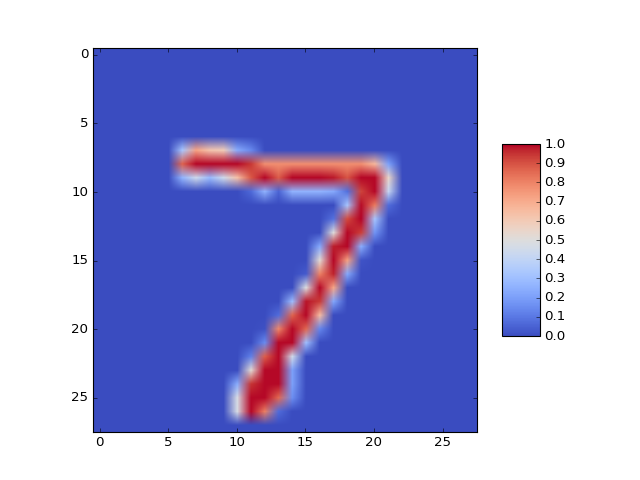

Perturbation


<IPython.core.display.Javascript object>


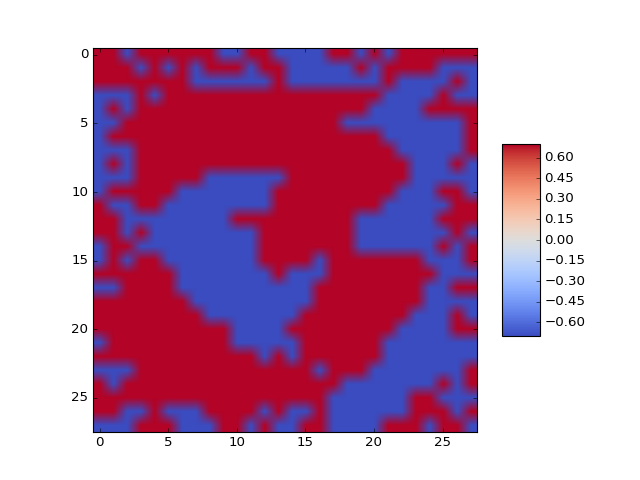

Input post-perturbation


<IPython.core.display.Javascript object>


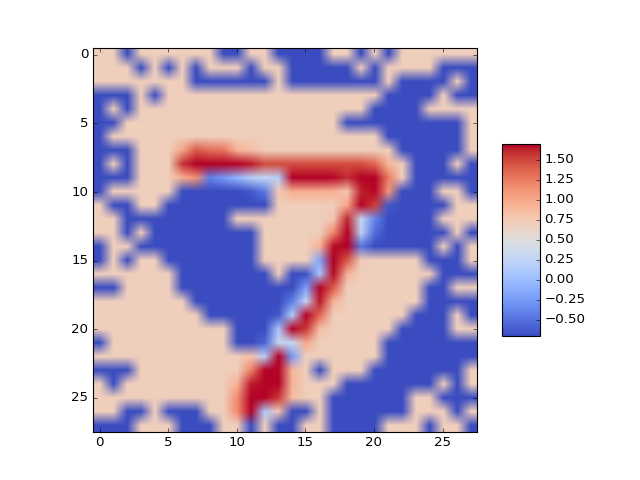

True class: 7
Predicted class: 3
Expected class: 3


In [56]:
fake_class = 3
prediction = adversarial(mnist.test.images[0], fake_class, True)
print "True class: " + str(np.argmax(mnist.test.labels[0]))
print "Predicted class: " + str(prediction)
print "Expected class: " + str(fake_class)